# Análisis de la supervivencia en el accidente Titanic

In [1]:
! pip install scikit-learn


In [2]:
! pip install langchain langchain_openai gradio chromadb pypdf

In [3]:
! pip install PyPDF2


In [4]:
! pip install beautifulsoup4


In [5]:
! pip install plotly


In [84]:
import pandas as pd
import numpy as np
import os
import requests
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from langchain_community.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate 
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import gradio as gr
from PyPDF2 import PdfFileReader
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report



In [7]:
df = pd.read_csv(r'C:\Users\alede\Desktop\PRIMER_PROYECTO\Titanic\titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Según el DF había 891 pasajeros. 
* PassengerId: Es un identificador único asignado a cada pasajero.
* Survived: Indica si el pasajero sobrevivió al naufragio del Titanic. Puede tener dos valores: 1 para indicar que sobrevivió y 0 para indicar que no sobrevivió.
* Pclass: Se refiere a la clase en la que viajaba el pasajero. Puede tener tres valores: 1 para primera clase, 2 para segunda clase y 3 para tercera clase.
* Name: Es el nombre del pasajero.
* Sex: Indica el sexo del pasajero, puede ser "male" (hombre) o "female" (mujer).
* Age: Es la edad del pasajero en años.
* SibSp: Se refiere al número de hermanos/cónyuges a bordo del Titanic.
* Parch: Indica el número de padres/hijos a bordo del Titanic.
* Ticket: Es el número de ticket del pasajero.
* Fare: Indica la tarifa que pagó el pasajero por su viaje.
* Cabin: Es el número de cabina del pasajero, aunque esta variable puede tener muchos valores faltantes.
* Embarked: Indica el puerto de embarque del pasajero. Puede ser "C" para Cherbourg, "Q" para Queenstown o "S" para Southampton.

## Pre-Análisis

El pre-análisis consiste en la exploración inicial y comprensión de la estructura y los contenidos del conjunto de datos antes de realizar análisis más profundos. Este proceso es crucial para obtener información sobre la calidad de los datos, identificar patrones, comprender las características clave y tomar decisiones informadas sobre cómo abordar el conjunto de datos.

* Nombre de las columnas

In [8]:
# se verifica que no hayan espacio en los nombres 
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

* Verificación de nulos

<Axes: >

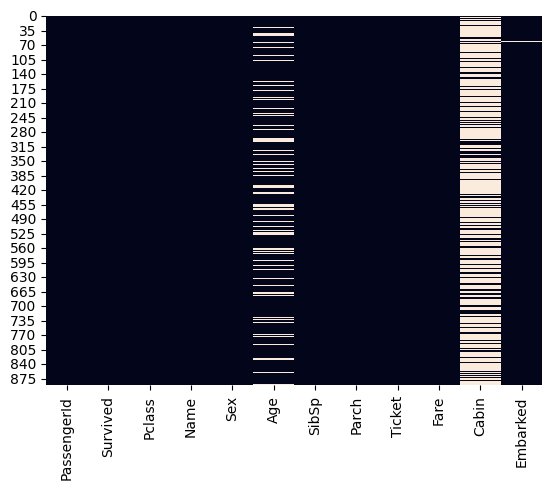

In [9]:
sns.heatmap(df.isnull(), cbar=False)

Mediante el mapa de calor se puede observar que hay varios nulos en las columnas Age y Cabin.

* Porcentaje de nulos en las columnas 

In [10]:
df.isnull().sum()/len(df)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

* Tipos de datos

In [11]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

* Datos duplicados

In [12]:
df.duplicated().sum()

0

* Cantidad de Filas y Columnas del DF

In [13]:
df.shape

(891, 12)

## Limpieza de Datos

* Corrección de valores nulos

La columna 'Cabin' cuenta con 77% de nulos por lo que se procederá a eliminarse. En cambio la columna 'Age' 19,8% y se procede a repararlo 

In [14]:
# Eliminar la columna Cabin pero crear un nuevo DF tener siempre el original. 

df_copia = df.copy()
cabin_columna = 'Cabin'
df_copia = df_copia.drop(columns =[cabin_columna])
# Desde ahora el DF se llama df_copia 

In [15]:
df_copia

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [16]:
mediana_edad= df_copia['Age'].median()
#Rellenar con la mediana los valores faltantes (se elije la mediana porque la variable es la edad)

In [17]:
df_copia['Age'].fillna(mediana_edad, inplace= True)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_95804\790990790.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copia['Age'].fillna(mediana_edad, inplace= True)


<Axes: >

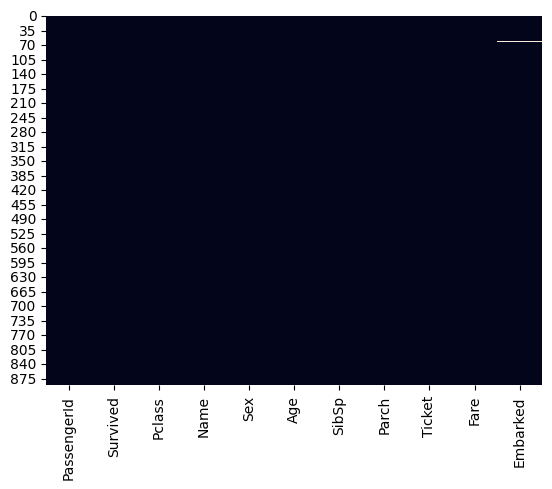

In [18]:
sns.heatmap(df_copia.isnull(), cbar=False)

* Conversión de la columna 'Age' de float a int

In [19]:
parte_decimal = df_copia['Age'].apply(lambda x: x - int(x))
print(parte_decimal)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
886    0.0
887    0.0
888    0.0
889    0.0
890    0.0
Name: Age, Length: 891, dtype: float64


In [20]:
cantidad_mayor_que_cero = (parte_decimal > 0)
cantidad_mayor_que_cero

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Name: Age, Length: 891, dtype: bool

Ver los valores de 'Age' con la condicion de mayores a cero

In [21]:
condicion = parte_decimal > 0 
cantidad_mayor_que_cero = df_copia[condicion]
cantidad_mayor_que_cero

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
57,58,0,3,"Novel, Mr. Mansouer",male,28.50,0,0,2697,7.2292,C
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,S
111,112,0,3,"Zabour, Miss. Hileni",female,14.50,1,0,2665,14.4542,C
116,117,0,3,"Connors, Mr. Patrick",male,70.50,0,0,370369,7.7500,Q
122,123,0,2,"Nasser, Mr. Nicholas",male,32.50,1,0,237736,30.0708,C
123,124,1,2,"Webber, Miss. Susan",female,32.50,0,0,27267,13.0000,S
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.50,0,2,230080,26.0000,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.50,0,0,A.5. 11206,8.0500,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.50,0,2,A/5. 851,14.5000,S
203,204,0,3,"Youseff, Mr. Gerious",male,45.50,0,0,2628,7.2250,C


## Análisis Exploratorio

* Cuantos bebes había a bordo del titanic?

In [22]:
bebes = df_copia[df_copia['Age'] < 1]


In [23]:
total_bebes = len(bebes)
total_bebes

7

* Cuantos niños  habia a bordo del Titanic?

Para saber cuantos niños habia en el Titanic primero se debe investigar de que edad a que edad se consideraba niño en los años 1912.

In [24]:
URL = 'https://es.wikipedia.org/wiki/Explotaci%C3%B3n_infantil'

In [25]:
response = requests.get(URL)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
content_div = soup.find('div', {'id': 'mw-content-text'})
paragraphs = content_div.find_all('p')[3]

for paragraph in paragraphs:
        print(paragraph.text)

else:
    print('No se pudo acceder a la página de Wikipedia')

El salario de aquellos niños que se dedicaban a trabajar tan solo representaba el 20-15 % del salario masculino adulto. Comenzaban a trabajar a una edad muy temprana, entre 7 y 8 años. Normalmente realizan labores específicas como vigilar el correcto funcionamiento de las máquinas (portadores de bobinas, devanadores de tramas), engrasar las máquinas. La primera hiladora de algodón era tan pequeña que las únicas personas capaces de trabajar con ellas o arreglarlas eran niños de ambos sexos, además enseñárselas a utilizar resultaba muy sencillo. Las labores les exponían a graves peligros. Hay datos de desfiguraciones faciales a causa del aceite hirviendo de las máquinas o al tratar con productos muy inflamables.
.mw-parser-output .flexquote{display:flex;flex-direction:column;background-color:#F9F9F9;border-left:3px solid #c8ccd1;font-size:90%;margin:1em 4em;padding:.4em .8em}.mw-parser-output .flexquote>.flex{display:flex;flex-direction:row}.mw-parser-output .flexquote>.flex>.quote{width

Según Wikipedia en los años 1900 los niños comenzaban a trabajar entre 7 y 8 años.

In [26]:
# La variable niños es considerado desde los 1 año a 7 años.
niños_a_bordo = df_copia[df_copia['Age'].between(1, 7)]
total_niños = len(niños_a_bordo)
total_niños

43

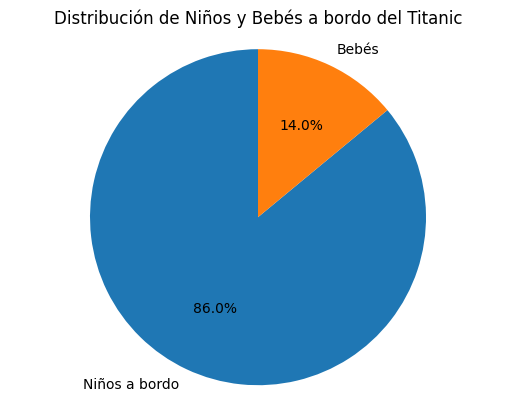

In [27]:
plt.pie([total_niños, total_bebes], labels=['Niños a bordo', 'Bebés'], autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Niños y Bebés a bordo del Titanic')
plt.axis('equal') 

# Mostrar el gráfico
plt.show()

* Cual era la edad de la persona más vieja a bordo?

In [28]:
mayor_edad = df_copia['Age'].max()
mayor_edad

80.0

* Cual era la edad promedio de pasajeros a bordo?

In [29]:
edad_promedio = df_copia['Age'].mean()
edad_promedio

29.36158249158249

* Total Pasajeros a bordo

Para determinar las variables de adultos hombres y mujeres se tiene en cuenta que las mujeres y hombres adultos son a partir de los 8 años en adelante. 

In [30]:
female = df_copia[(df_copia['Age'] > 8) & (df_copia['Sex'] == 'female')]
total_female = len(female)
male = df_copia[(df_copia['Age'] > 8) & (df_copia['Sex'] == 'male')]
total_male = len(male)

In [31]:
total_female

288

In [32]:
total_male

549

In [33]:
pasajeros = ["total_niños", "total_bebes", "total_female", "total_male"]
cantidades = [43, 7, 288, 549]  # Las cantidades correspondientes a cada categoría

fig = px.line(x=pasajeros, y=cantidades, color=px.Constant("1912"),
              labels=dict(x="Pasajeros", y="Cantidad", color="Periodo de tiempo"))
fig.add_bar(x=pasajeros, y=cantidades, name="Distribución de la cantidad de pasajeros")
fig.show()

In [34]:
fig.write_image("grafico_pasajeros.png")

* Sobrevivientes

In [35]:
total_sobrevivientes = df_copia['Survived'].value_counts()
total_sobrevivientes

Survived
0    549
1    342
Name: count, dtype: int64

In [36]:
sobrevivientes = (df_copia['Survived'] ==1)
no_sobrev = (df_copia['Survived'] ==0)

0 = no sobrevivieron
1 = si sobrevivieron. Sobrevivieron 342 pasajeros

In [37]:
pasajeros = df_copia['PassengerId'].sum()

In [38]:
fig = go.Figure()
r1 = [20, 30, 40, 50, 60] 
r2 = [10, 25, 35, 45, 55]
# primer circulo
fig.add_trace(go.Scatter(
    x=sobrevivientes,
    y=[1] * len(sobrevivientes),
    mode="markers",
    marker=dict(size=r1, color='blue', opacity=0.5),
    name= 'Sobrevivientes = 342'))
# segundo circulo
fig.add_trace(go.Scatter(
    x=no_sobrev,
    y= [2] * len(sobrevivientes),
    mode="markers",
    marker=dict(size=r2, color='red', opacity=0.5),
    name='No Sobrevivientes = 549'))
# Ajuste del grafico
fig.update_layout(
    title='Distribución de Sobrevivientes en el Titanic',
    yaxis=dict(
        tickvals=[1, 2],
        ticktext=['Sobrevivientes', 'No sobrevivientes'],
    ),
    xaxis=dict(range=[0, 11]),
)
fig.show()

In [78]:
fig.write_image("grafico_sobrevivientes.png")

* Verificamos en pdfs si sobrevivieron 342 pasajeros

Para eso vamos a importar documentos con `chat with docs`

Fuente : `Códigos` proveidos por Demetrio

In [39]:
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0)

In [40]:
embedding = OpenAIEmbeddings()

In [41]:
pdf1 = "https://e00-elmundo.uecdn.es/aula/laminas/titanic.pdf"
pdf2 = "https://nieonline.com/sentinel/downloads/curricula/titanic.pdf"
pdf3 = "https://www.senate.gov/artandhistory/history/resources/pdf/TitanicReport.pdf"
pdf4 = "https://www.titanicinquiry.org/downloads/USInq.pdf"
#El siguiente paso consiste en crear un array que nos permita entrar al bucle posterior
urls = [pdf1, pdf2, pdf3, pdf4]

In [42]:
# Separar por páginas
pages = []

for url in urls:
    loader = PyPDFLoader(url)
    pages += loader.load_and_split()

In [43]:
len(pages) #total de paginas en todos los pdfs

1236

Base de datos vectorial con chroma

In [44]:
vectorstore = Chroma.from_documents(
    documents = pages, 
    embedding=embedding
    )

In [45]:
retriever = vectorstore.as_retriever()

Template Prompt

In [46]:
template = """

        ###INSTRUCCIONES: 
        Eres un asistente de IA dedicado a responder preguntas de manera educada y profesional. Debes proporcionar una respuesta útil al usuario. 
        
        En tu respuesta, POR FAVOR SIEMPRE:
          (0) Sé un lector atento a los detalles: lee la pregunta y el contexto y entiende ambos antes de responder.
          (1) Comienza tu respuesta con un tono amigable y reitera la pregunta para que el usuario esté seguro de que la entendiste.
          (2) Si el contexto te permite responder a la pregunta, escribe una respuesta detallada, útil y fácil de entender, con fuentes referenciadas en el texto. SI NO: no puedes encontrar la respuesta, responde con una explicación, comenzando con: "No pude encontrar la información en las leyes a las que tengo acceso".
          (3) Debajo de la respuesta, por favor enumera todas las fuentes referenciadas (es decir, párrafos legales que respaldan tus afirmaciones).
          (4) Ahora que tienes tu respuesta, eso es increíble - revisa tu respuesta para asegurarte de que responde a la pregunta, es útil y profesional y está formateada para ser fácilmente legible.
        
        
        PIENSA PASO POR PASO 
        ###
        
      Responde a la siguiente pregunta utilizando el contexto proporcionado.
        ### Question: {question} ###
        ### Context: {context} ###     
        ### Respuesta Útil con Fuentes:

        """

    # Creamos nuestra template de prompt
prompt = PromptTemplate.from_template(template)

Cadena

In [47]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [48]:
ans = chain.invoke("cuantos pasajeros sobrevivieron?")

print(ans)

¡Hola! Según los informes, el Carpathia rescató a 705 sobrevivientes del Titanic. Trágicamente, se perdieron 1,502 vidas en el desastre. Por lo tanto, el número de pasajeros que sobrevivieron fue de 705.

Fuentes:
- https://nieonline.com/sentinel/downloads/curricula/titanic.pdf
- https://www.titanicinquiry.org/downloads/USInq.pdf


* Sobrevivian más hombres o mujeres?

In [50]:
# Se usa el parametro == 1 para filtrar de Survived solo los sobrevivientes 
sob_muj = df_copia[(df_copia['Survived'] == 1 )& (df_copia['Sex'] == 'female')]
sob_muj = len(sob_muj)

sob_hom = df_copia[(df_copia['Survived'] == 1 )& (df_copia['Sex'] == 'male')]
sob_hom = len(sob_hom)

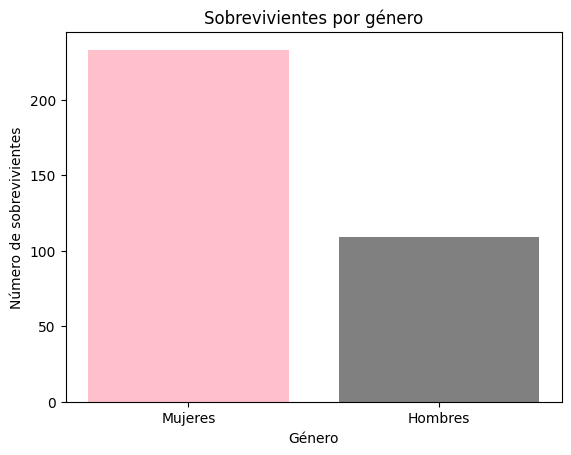

In [51]:
# Crear el gráfico de barras
plt.bar(['Mujeres', 'Hombres'], [sob_muj, sob_hom], color=['pink', 'grey'])

# Agregar título y etiquetas
plt.title('Sobrevivientes por género')
plt.xlabel('Género')
plt.ylabel('Número de sobrevivientes')

# Mostrar el gráfico
plt.show()

In [52]:
ans = chain.invoke("Quienes sobrevivieron? Más hombres o mujeres?")

print(ans)

¡Hola! Según los documentos proporcionados, hubo un total de 750 personas salvadas del Titanic, de las cuales 210 pertenecían a la tripulación. De esos 210, solo 15 eran mujeres. Además, de los pasajeros de primera clase, sobrevivieron 131 mujeres y 68 hombres. De los pasajeros de segunda clase, sobrevivieron 106 mujeres y niños, y 12 hombres. Y de los pasajeros de tercera clase, sobrevivieron 93 mujeres y 85 hombres. Por lo tanto, en general, sobrevivieron más mujeres que hombres. 

Fuentes:
- https://www.titanicinquiry.org/downloads/USInq.pdf (páginas 555, 428, 21, 1003)


* Cual es el % de sobrevivientes según el puerto de embarque?

In [53]:
df_copia['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [54]:
total_p_c = (df_copia['Embarked'] == 'C')
total_p_c.sum()

168

In [55]:
puerto_C = df_copia[(df_copia['Survived'] == 1 )& (df_copia['Embarked'] == 'C')]
puerto_C = len(puerto_C)

puerto_S = df_copia[(df_copia['Survived'] == 1 )& (df_copia['Embarked'] == 'S')]
puerto_S = len(puerto_S)

puerto_Q = df_copia[(df_copia['Survived'] == 1 )& (df_copia['Embarked'] == 'Q')]
puerto_Q = len(puerto_Q)

In [56]:
puerto_C

93

In [57]:
Porcentaje_PC = (93/168)*100
Porcentaje_PC

55.35714285714286

In [58]:
total_p_S = (df_copia['Embarked'] == 'S')
total_p_S.sum()

644

In [59]:
puerto_S

217

In [60]:
porcentaje_P_S = (217/644)*100
porcentaje_P_S

33.69565217391305

In [61]:
total_p_q = (df_copia['Embarked'] == 'Q')
total_p_q.sum()

77

In [62]:
puerto_Q

30

In [63]:
porcentaje_P_Q = (30/77)*100
porcentaje_P_Q

38.961038961038966

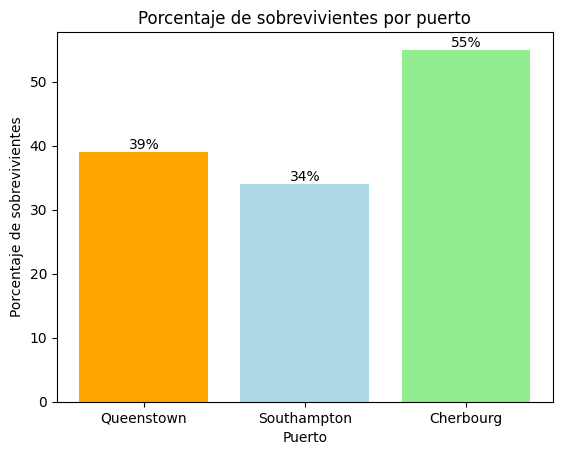

In [64]:
# Grafico de barras apiladas de Matplotlib
puertos = ['Queenstown', 'Southampton', 'Cherbourg']
porcentajes = [39,34,55]
colores = ['orange', 'lightblue', 'lightgreen']
plt.bar(puertos, porcentajes, color=colores)
# Agregar etiquetas con los porcentajes (extraido de chatgpt)
for i, porcentaje in enumerate(porcentajes):
    plt.text(i, porcentaje, f"{porcentaje}%", ha='center', va='bottom')
plt.title('Porcentaje de sobrevivientes por puerto')
plt.xlabel('Puerto')
plt.ylabel('Porcentaje de sobrevivientes')
plt.show()


* Ubicación de los puertos

In [65]:
# GRAFICAR GeoJSON Layers (Extraido de la pagina de plotly : https://plotly.com/python/filled-area-on-mapbox/)

# Coordenadas de los puertos
puertos = {
    'Cherbourg': {'lon': -1.6286, 'lat': 49.6301},
    'Queenstown': {'lon': -9.4775, 'lat': 51.8492},
    'Southampton': {'lon': -1.4043, 'lat': 50.9025}
}
    # Crear el gráfico de dispersión en el mapa
fig = go.Figure(go.Scattermapbox(
    mode="markers",
    lon=[puertos['Cherbourg']['lon'], puertos['Queenstown']['lon'], puertos['Southampton']['lon']],
    lat=[puertos['Cherbourg']['lat'], puertos['Queenstown']['lat'], puertos['Southampton']['lat']],
    marker={'size': 20, 'color': ["cyan"]}
))

# Actualizar el diseño del mapa
fig.update_layout(
    mapbox={
        'style': "open-street-map",
        'center': {'lon': -1.6, 'lat': 50},  # Centro del mapa
        'zoom': 4,  # Tamaño del zoom
        'layers': [{
            'source': {
                'type': "FeatureCollection",
                'features': [{
                    'type': "Feature",
                    'geometry': {
                        'type': "MultiPolygon",
                        'coordinates': [[[
                            [-73.606352888, 45.507489991], [-73.606133883, 45.50687600],
                            [-73.605905904, 45.506773980], [-73.603533905, 45.505698946],
                            [-73.602475870, 45.506856969], [-73.600031904, 45.505696003],
                            [-73.599379992, 45.505389066], [-73.599119902, 45.505632008],
                            [-73.598896977, 45.505514039], [-73.598783894, 45.505617001],
                            [-73.591308727, 45.516246185], [-73.591380782, 45.516280145],
                            [-73.596778656, 45.518690062], [-73.602796770, 45.521348046],
                            [-73.612239983, 45.525564037], [-73.612422919, 45.525642061],
                            [-73.617229085, 45.527751983], [-73.617279234, 45.527774160],
                            [-73.617304713, 45.527741334], [-73.617492052, 45.527498362],
                            [-73.617533258, 45.527512253], [-73.618074188, 45.526759105],
                            [-73.618271651, 45.526500673], [-73.618446320, 45.526287943],
                            [-73.618968507, 45.525698560], [-73.619388002, 45.525216750],
                            [-73.619532966, 45.525064183], [-73.619686662, 45.524889290],
                            [-73.619787038, 45.524770086], [-73.619925742, 45.524584939],
                            [-73.619954486, 45.524557690], [-73.620122362, 45.524377961],
                            [-73.620201713, 45.524298907], [-73.620775593, 45.523650879]
                        ]]]
                    }
                }]
            },
            'type': "fill", 'below': "traces", 'color': "royalblue"
        }]
    },
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

# Mostrar el gráfico
fig.show()


In [80]:
ans = chain.invoke("Cuales son los puertos de donde zarpó el titanic?")

print(ans)

¡Hola! Según el contexto proporcionado, el Titanic zarpó de tres puertos en su primer y único viaje: Southampton en Gran Bretaña, Cherbourg en Francia y Queenstown en Irlanda. Estos fueron los puertos de donde partió el Titanic en su trágico viaje inaugural en 1912.

Fuentes:
- https://e00-elmundo.uecdn.es/aula/laminas/titanic.pdf


* Cuántos niños (0-7 años) sobrevivieron?


In [66]:
niños_sobrevivientes = len(df_copia[(df_copia['Survived'] == 1) & (df_copia['Age'] <= 7)])
niños_sobrevivientes

34

* Cuántos niños sobrevivieron de cada 'Pclass'?

In [67]:
sobrev_PC1 = len(df[(df['Pclass'] == 1) & (df['Age'] <=7) & (df['Survived'] == 1)])
sobrev_PC1

2

In [68]:
sobrev_PC2 = len(df[(df['Pclass'] == 2) & (df['Age'] <=7) & (df['Survived'] == 1)])
sobrev_PC2

15

In [69]:
sobrev_PC3 = len(df[(df['Pclass'] == 3) & (df['Age'] <=7) & (df['Survived'] == 1)])
sobrev_PC3

17

In [70]:
ans = chain.invoke("Cuantos niños llegaron con vida?")

print(ans)

¡Hola! Según el testimonio de Mr. Burke, en el bote No. 13 llegaron alrededor de 60 personas, incluyendo aproximadamente cuatro niños. No se menciona que ningún otro bote haya llegado con niños. 

Fuentes:
- Testimonio de Mr. Burke en el documento del Titanic Inquiry: https://www.titanicinquiry.org/downloads/USInq.pdf (páginas 824, 830)


* Valores unicos de la columna 'Name'

In [71]:
valores_unicos_name = df['Name'].unique()
valores_unicos_name

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

Los nombres de las mujeres que estan relacionadas con un hombre está en ()

* Ticket

In [72]:
valores_unicos_ticket = df_copia['Ticket'].unique()
valores_unicos_ticket

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

Averiguar que significan las letras en los tickets

In [73]:
#primero filtrar los tickets por cada 'Pclass'
#Tickets de primera clase
tickets_pclass_1 = df_copia[df_copia['Pclass'] == 1]['Ticket'] 
letras = tickets_pclass_1.str.extract(r'([A-Za-z]+)')
letras_filtradas = letras[0].dropna().values #convertir en array para ver todo
print(letras_filtradas)

['PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'W' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC'
 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC'
 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'WE' 'PC' 'PC' 'PC'
 'PC' 'PC' 'PC' 'PC' 'PC' 'F' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC' 'PC'
 'WE' 'PC' 'PC' 'PC' 'PC' 'PC']


In [74]:
#Letras de los tickets de segunda clase 
tickets_pclass_2 = df_copia[df_copia['Pclass'] == 2]['Ticket'] 
letras_pc2 = tickets_pclass_2.str.extract(r'([A-Za-z]+)')
letras_filtradas2 = letras_pc2[0].dropna().values
print(letras_filtradas2)

['C' 'SC' 'C' 'C' 'C' 'C' 'S' 'SO' 'S' 'C' 'SC' 'C' 'S' 'C' 'SC' 'F' 'W'
 'SW' 'C' 'C' 'SCO' 'W' 'C' 'SC' 'P' 'F' 'SC' 'S' 'SC' 'SC' 'C' 'F' 'C'
 'F' 'C' 'SC' 'C' 'W' 'F' 'SC' 'C' 'S' 'SC' 'SC' 'C' 'S' 'S' 'C' 'SC' 'S'
 'C' 'S' 'S' 'S' 'SC' 'P' 'C']


In [75]:
#Letras de los tickets de tercera clase 
tickets_pclass_3 = df_copia[df_copia['Pclass'] == 3]['Ticket'] 
letras_pc3 = tickets_pclass_3.str.extract(r'([A-Za-z]+)')
letras_filtradas3 = letras_pc3[0].dropna().values
print(letras_filtradas3)

['A' 'STON' 'PP' 'A' 'A' 'S' 'A' 'CA' 'S' 'CA' 'W' 'SOTON' 'C' 'STON' 'A'
 'C' 'SOTON' 'A' 'STON' 'W' 'A' 'A' 'Fa' 'SOTON' 'CA' 'STON' 'LINE' 'CA'
 'CA' 'A' 'SOTON' 'A' 'STON' 'SOTON' 'PP' 'A' 'W' 'STON' 'A' 'LINE' 'C'
 'A' 'LINE' 'A' 'A' 'CA' 'C' 'SOTON' 'C' 'C' 'STON' 'CA' 'PP' 'STON'
 'STON' 'STON' 'A' 'A' 'SOTON' 'STON' 'W' 'A' 'A' 'SOTON' 'CA' 'A' 'A' 'C'
 'SOTON' 'A' 'C' 'C' 'SOTON' 'SOTON' 'SOTON' 'A' 'A' 'STON' 'A' 'STON' 'A'
 'LINE' 'SOTON' 'A' 'STON' 'S' 'CA' 'STON' 'A' 'CA' 'CA' 'STON' 'W' 'STON'
 'C' 'SOTON' 'W' 'SOTON' 'C' 'CA' 'A' 'STON' 'C' 'SOTON' 'C' 'CA' 'CA'
 'SOTON' 'W']


In [82]:
# Tickets más barato
ticket_min = df_copia['Ticket'].min()
ticket_min

'110152'

In [83]:
# Tickets más caro
ticket_max = df_copia['Ticket'].max()
ticket_max

'WE/P 5735'